# Read me
To run this notebook __properly__
- Run the first cell only Shft+Enter
- Adjust the settings values
- Click the Continue button

In [1]:


from helpers import *


plt.figure(figsize=(30, 7))
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')
SUP_file_name_format = 'house{house}/{appliance}/h{house}_{appliance}{i:02d}.csv'

########################################################################
#                           I M P O R T A N T
#                       CONFIGURE THESE VARIABLES
########################################################################
appliance='dishwasher'
house='1'
window_size= 50
trim_below=50

wig_appliance = widgets.Dropdown(
    options = ['dryer','dishwasher','washer'],
    description='Appliance:')


wig_house=widgets.RadioButtons(
    options=['1', '2'],
    description='House number:')


wig_window_size = widgets.IntSlider(    
    min=5,
    max=400,
    step=5,
    layout={'width': '400'},
    description='Moving Window Size:',
    value=60)
wig_trim_below = widgets.IntSlider(    
    min=1,
    max=200,
    step=1,
    layout={'width': '400'},
    description='Trim below:',
    value=50)


def run_all(ev):
    appliance=wig_appliance.value
    house=wig_house.value
    window_size= wig_window_size.value
    trim_below =wig_trim_below.value
    display(Javascript('IPython.notebook.execute_cells_below()'))

display(Markdown('# Settings'))

display(wig_appliance)
display(wig_house)
display(wig_window_size)
display(wig_trim_below)

button = widgets.Button(description="Continue")
button.on_click(run_all)
display(button)

display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .rendered_html { background:orange !important; }
</style>'''))



# Settings

Dropdown(description='Appliance:', options=('dryer', 'dishwasher', 'washer'), value='dryer')

RadioButtons(description='House number:', options=('1', '2'), value='1')

IntSlider(value=60, description='Moving Window Size:', layout=Layout(width='400'), max=400, min=5, step=5)

IntSlider(value=50, description='Trim below:', layout=Layout(width='400'), max=200, min=1)

Button(description='Continue', style=ButtonStyle())

In [2]:
appliance=wig_appliance.value
house=wig_house.value
window_size= wig_window_size.value
trim_below =wig_trim_below.value
print(appliance)
print(house)
print(window_size)
print(trim_below)


dryer
1
60
50


In [3]:
# import plotly.graph_objects as go
# import plotly.express as px
# df = SUPs[len(SUPs)-1]
# fig = px.line(df, x="time", y="dryer", title='Life expectancy in Canada')
# fig.show()

# time = SUPs[len(SUPs)-1]['time'].values.tolist()
# power = SUPs[len(SUPs)-1][f'{appliance}'].values.tolist()
# fig = go.Figure(data=go.Bar(x=time,y=power))
# fig.show()


# SUP preparation

- Smoothing subs using moving median to maintain vertical edges and reduce lagging or leading the edge.
- Trimming SUPs by removing the leading and traling zero-power samples

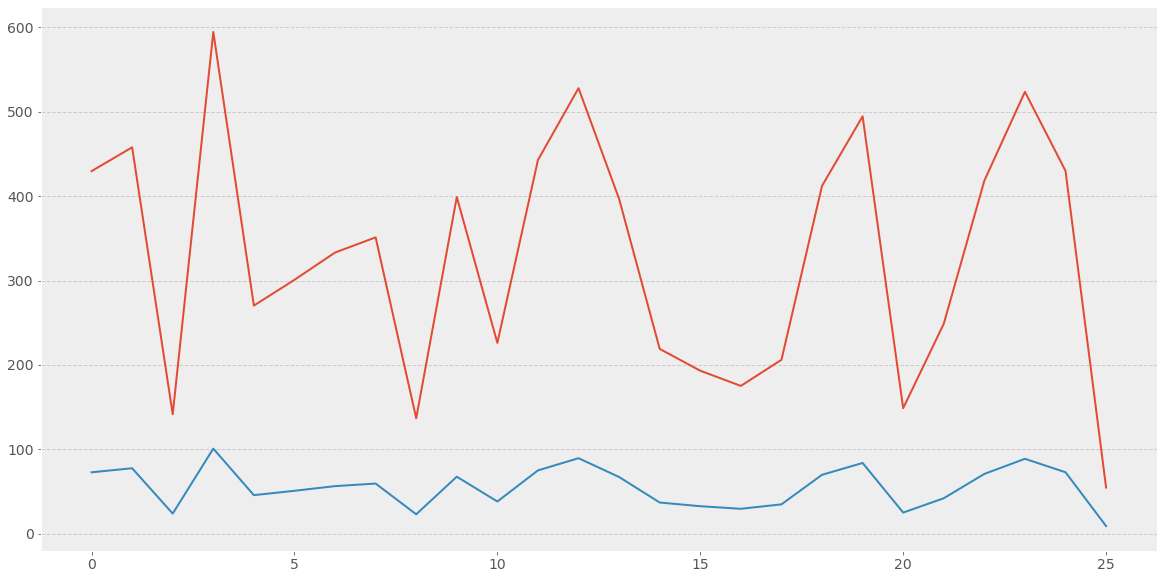

In [4]:
# convert SUPs into trimmed and smoothed lists
SUPs = read_SUPs(house,appliance)
trimmedSUPs=[]
smoothedSUPs=[]
for i in range(0,len(SUPs)):
    lst= SUPs[i][f'{appliance}'].values.tolist()
    trimmed = trim_list_under(lst,trim_below)
    trimmedSUPs.append(trimmed)
    smoothed = moving_median(trimmed, window_size)
    smoothedSUPs.append(smoothed)

# for i in range(0,len(SUPs)):
#     plt.figure(i)
#     myplot(trimmedSUPs[i])
#     myplot(smoothedSUPs[i],"Sample Number", "Power W/H",f"{appliance}-H{house}-SUP{i}")
#     plt.savefig(f'eps/dryer/dryer-{i}.eps', format='eps')

    
# calculate costs
kwh=[]
costsoff=[]
costson=[]
off=1
on=0.17
numperweek = 3
for i in range(0, len(trimmedSUPs)):
    lst= trimmedSUPs[i]
    costsoff.append(round( sum(lst)/1000/3600*numperweek * 52 *off,2))
    costson.append(round( sum(lst)/1000/3600*numperweek * 52 *on,2))
myplot(costsoff)
myplot(costson)


# the window_size of the moving median is changed.

moving median maintains the position of the edge no matter of the window size

moving average skews the edge

higher values of the window size may remove thin dips/spikes. Lower values may keep the noise.

resource for Euc dist
https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy

https://www.researchgate.net/publication/254861501_CID_An_efficient_complexity-invariant_distance_for_time_series

write the general formula and then the normalized formula I used

the abrupt change in the second figure is due to removing short states from the SUP as the window size getting larger. The initial difference btweeen trimmed and smoothed is due to removing all the spikes at the begining of each state (the inrush current) which is usually contributes to high value of power for a very short period of time. 

in the second figure, higher values of the plot means higher difference btweeen trimmed and smoothed and some of the major topographies have been removed. As the plot getting more flat, this means that the smoothing preserved all major topographies and removed just the noise.




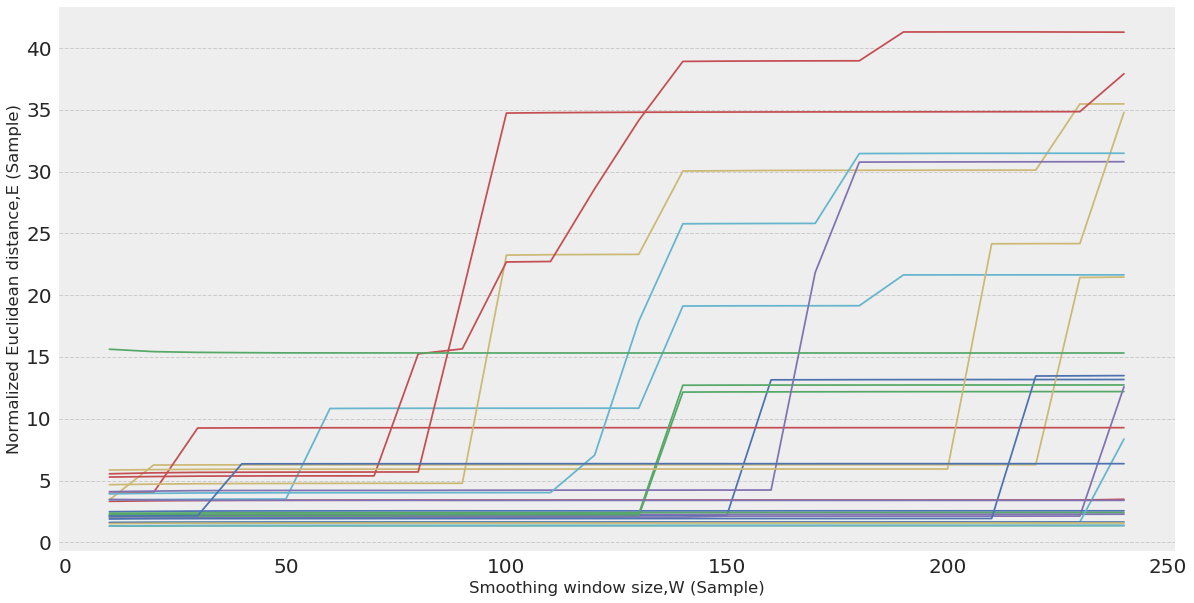

In [57]:
from scipy.spatial import distance # Euclidean

if house =='1':
    trimmed = trimmedSUPs[5]#[0:2600]
if house =='2':
    trimmed = trimmedSUPs[1]#[0:1000]
    
for h in range(0,len(SUPs)):
    trimmed = trimmedSUPs[h]
    normalized_euc_dist=[]
    window_sizes=[]
    for i in range(10,250,10):
        #plt.figure(i)
        smoothed = moving_median(trimmed, i)
        #myplot(smoothed,"samples","smoother power","the impact of smoothing window size on SUPs")

        dist = distance.euclidean(smoothed, trimmed)/len(trimmed)

        window_sizes.append(i)
        normalized_euc_dist.append(dist)

    plt.figure(i)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams['axes.facecolor'] = '#eeeeee'
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.grid(axis='y', color = '#cccccc', linestyle = '--', linewidth = 1)
    plt.grid(axis='x', color = '#eeeeee', linestyle = '--', linewidth = 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xlabel('Smoothing window size,W (Sample)')
    plt.ylabel('Normalized Euclidean distance,E (Sample)')
#     plt.title('The Euc distance between trimmed vs smoothed SUPS using moving median with variation in the window size')
    plt.plot(window_sizes,normalized_euc_dist)
    plt.savefig('eps/smoothSize_normDist.eps', format='eps')

# DTW 

- Computing DTW distance among each pair of SUPS
- Results are shown in 1-D line plot to see variation.
- It is also shown as a heatmap to enphasize clusters


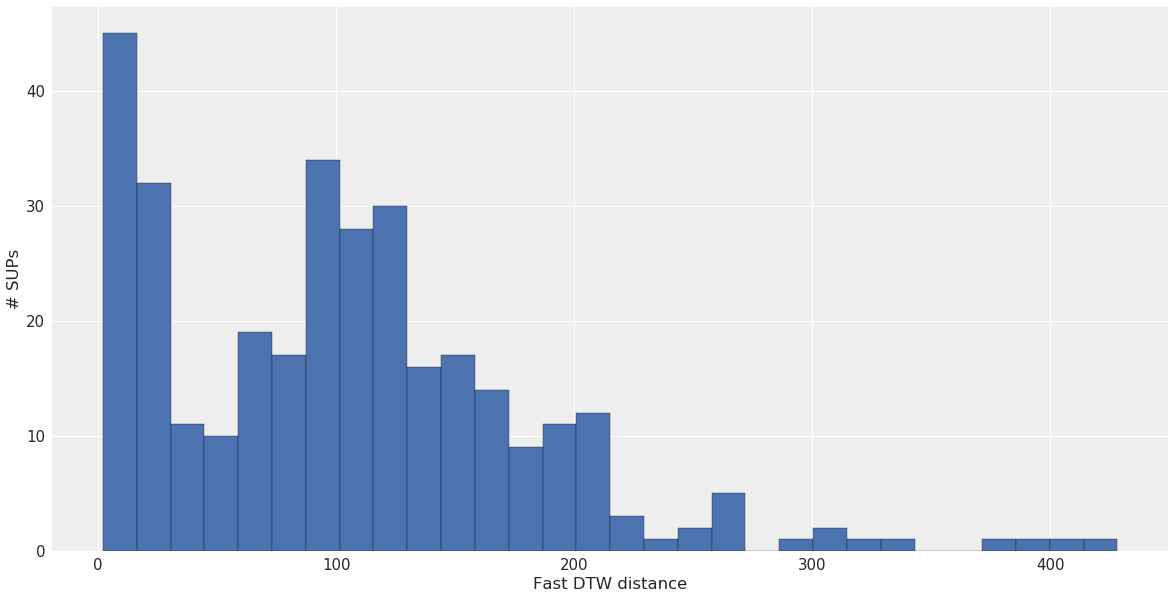

In [58]:
#All distances
distances1D=[]
distances2D=[]

#choose
# SUPlst = trimmedSUPs
SUPlst = smoothedSUPs

for i in range(0,len(SUPlst)):
    distances=[]
    for j in range(0,len(SUPlst)):
            distance, path = fastdtw(SUPlst[i], SUPlst[j])
            distance =distance/(len(SUPlst[i])+len(SUPlst[j]))
            distances.append(distance)
            if j>i:
                distances1D.append(distance)
            #print('dist'+str(i)+" - "+str(j)+" = "+str(distance))
    distances2D.append(distances)
    
## line plot - not good    
# plt.xlabel("Experiment #")
# plt.ylabel("Normalized Distance")        
# myplot(distances1D)
# plt.savefig('destination_path.eps', format='eps')

plt.figure()
plt.hist(distances1D, bins=30, edgecolor='black')
plt.xlabel("Fast DTW distance")
plt.ylabel("# SUPs")
plt.savefig('destination_path.eps', format='eps')
plt.show()


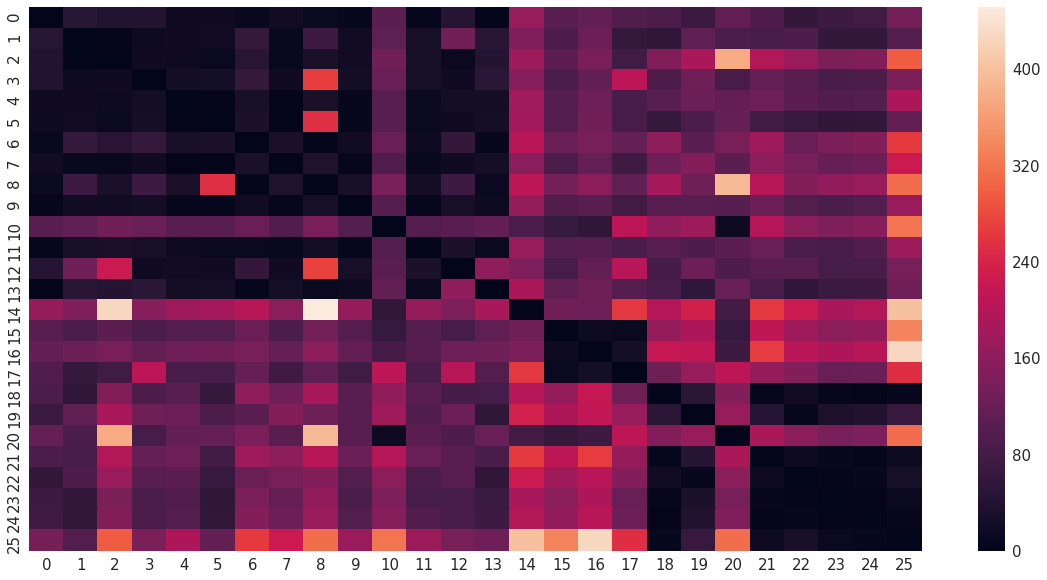

In [59]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=1.5)

# #make it triangle
# for i in range(len(distances2D)):
#     for j in range(len(distances2D)):
#         if j>i:
#             distances2D[i][j]=400

ax = sns.heatmap(distances2D)
ax.figure.savefig("eps/heat.eps",dpi=300)

In [9]:
clusters=[]

# house=2
# appliance='dryer'
# read_prepare_SUPs()
clusters.append([1,'dryer','L', [0,1,2,3,4,5,6,7,8,9,11,12,13] ]) #10,
clusters.append([1,'dryer','M', [15,16,17] ])
clusters.append([1,'dryer','H', [18,19,21,22,23,24,25] ]) #20,

# house=2
# appliance='dryer'
# read_prepare_SUPs()
# clusters.append([2,'dryer','L', [0,1,2,3,4,5,6] ]) 
# clusters.append([2,'dryer','M', [7,8] ])
# clusters.append([2,'dryer','H', [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] ])



# clusters.append([1,'dishwasher','L', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] ]) 
# clusters.append([1,'dishwasher','M', [25,26,27,28,29,30,31,32] ]) 

# clusters.append([2,'dishwasher','L', [0,1,2,3,4,5,6,7,8,9,10] ]) 


# clusters.append([1,'washer','L', [0,1,2,3,4,5] ]) 
# clusters.append([1,'washer','M', [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] ]) 


# clusters.append([2,'washer','L', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] ]) 
# clusters.append([2,'washer','M', [15,16,17,18,19] ]) 
# clusters.append([2,'washer','H', [20,21,22,24,25,26] ]) #23,

all_mean=[]
all_stdv=[]
for i in range(0,len(clusters)):
    clusterSUPs =clusters[i][3]
    mean=[]
    stdv=[]
    distances=[]
    for j in range(0,len(clusterSUPs)):
        for k in range(j+1,len(clusterSUPs)):
            distance, path = fastdtw(SUPlst[clusterSUPs[j]], SUPlst[clusterSUPs[k]])
            distance =distance/(len(SUPlst[clusterSUPs[j]])+len(SUPlst[clusterSUPs[k]]))
            distances.append(distance)

            #print('dist'+str(j)+" - "+str(k)+" = "+str(distance))
    mean= np.mean(distances)
    stdv= np.std(distances)
    all_mean.append(mean)
    all_stdv.append(stdv)
    
print('means')
print(all_mean)
print('stdv')
print(all_stdv)

means
[32.70447578077531, 17.22703841208814, 18.743359699457763]
stdv
[44.912951864653365, 5.35998696188329, 17.7990102315228]


The mean in the table corresponds to the darker color in the map. Darker color of the cluster (lower mean value) means higher similarity while red and light colors (higher mean values) means less similarity.

The stdv in the table corresponds to the consistency of the colors within the cluster. 

### Mean
|house|appliace| op-1 | op-2 |op-3 |
| --- |
|1 | dryer |32.70447578077531| 17.22703841208814| 18.743359699457763|
|2 | dryer | 77.62607612583217| 203.18679026651216| 208.23865828104323|
|1 | dishwasher | 31.91627504039637| 8.453634898910257| -|
|2 | dishwasher | 0.7594897652980692| -| -|
|1 | washer | 10.03806185432967| 9.06360232647038| -|
|2 | washer | 7.647593883978964| 9.288396442997383| 6.23818292561404|


### stdv
|house|appliace| op-1 | op-2 |op-3 |
| --- |
|1 | dryer |44.912951864653365| 5.35998696188329| 17.7990102315228|
|2 | dryer | 45.221209376723344| 0.0| 93.14741538273752|
|1 | dishwasher | 30.10945356245825 | 4.905953696707307| -|
|2 | dishwasher | 0.3582005554415548| -| -|
|1 | washer | 3.6888633884802| 3.738028127544137|-|
|2 | washer | 2.7522428472286653| 3.1537764961662655| 1.6480269772583511|

# Indicator Function
- Calculate the indicator function
- Apply smoothing over the indicator function
- Apply threshold

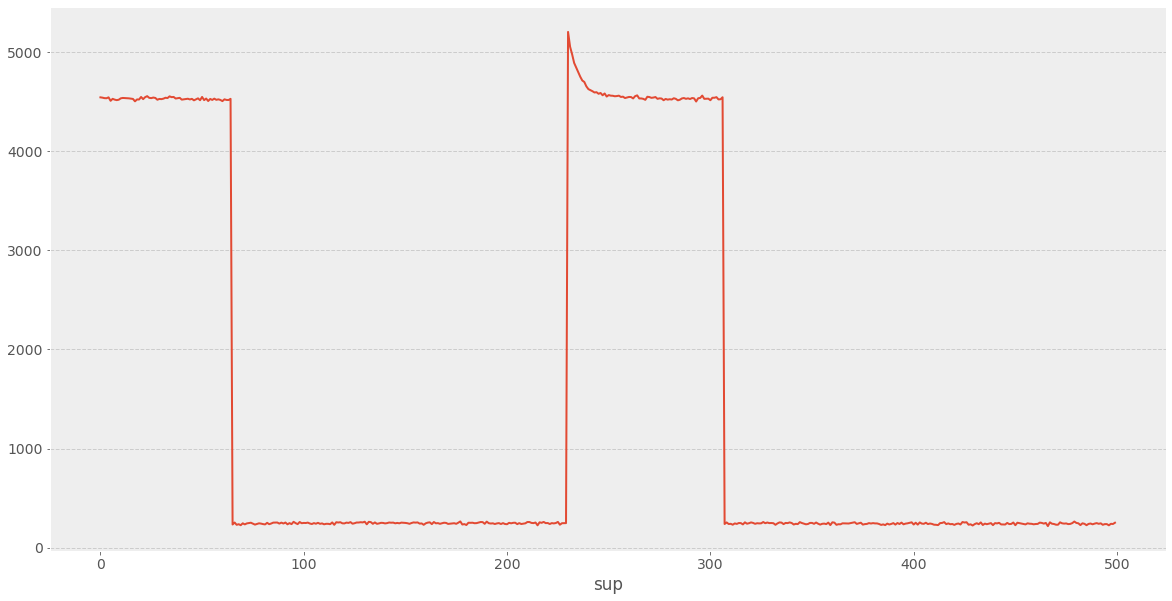

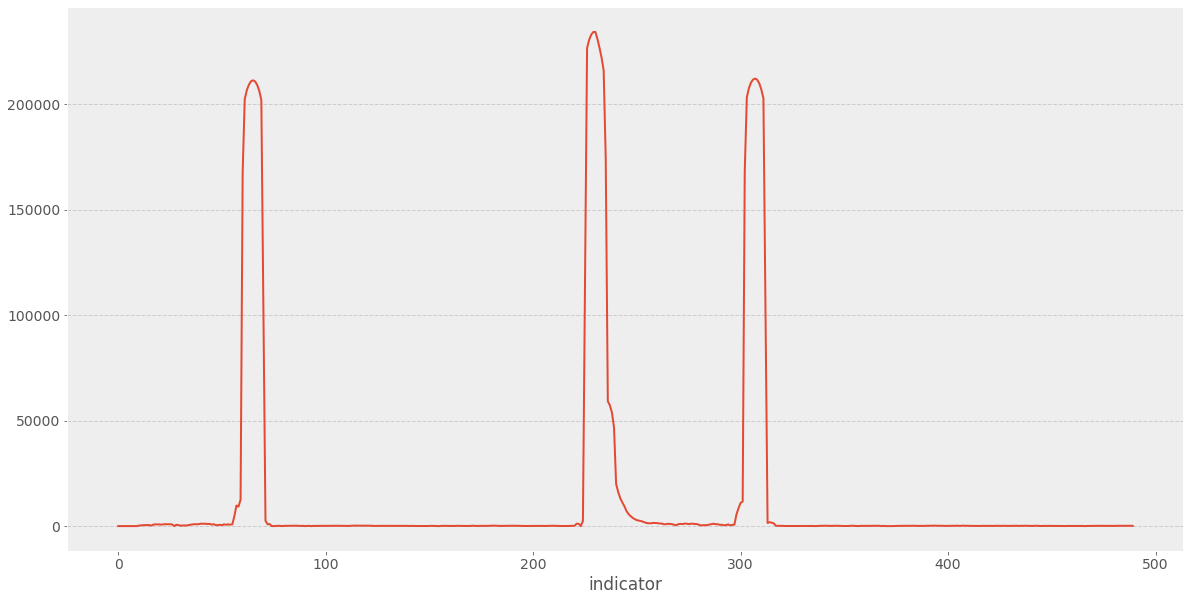

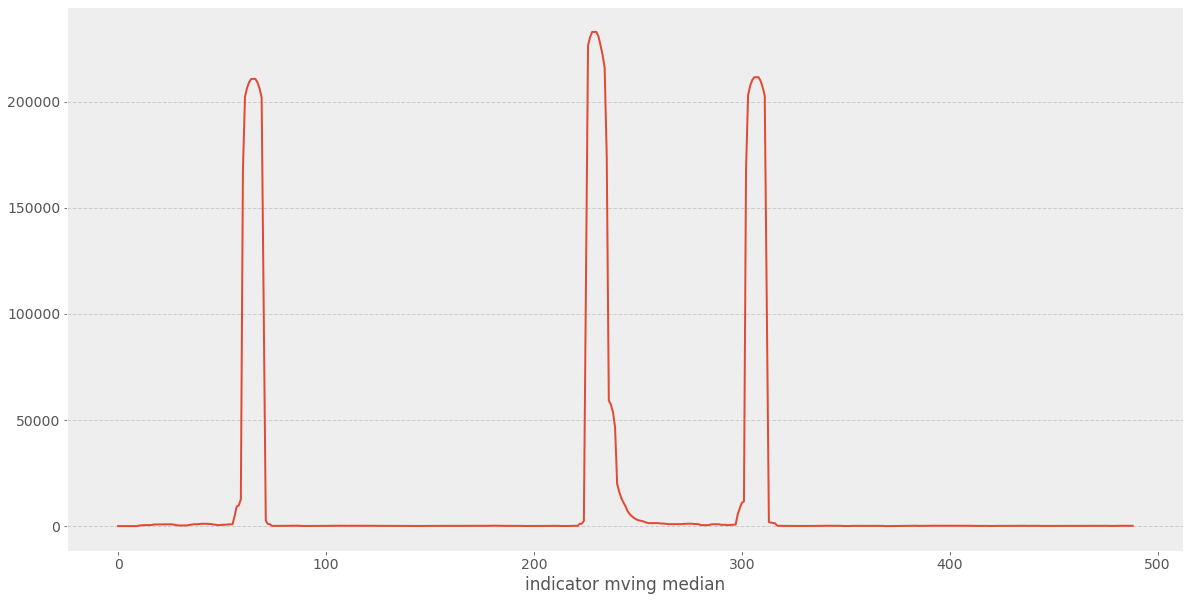

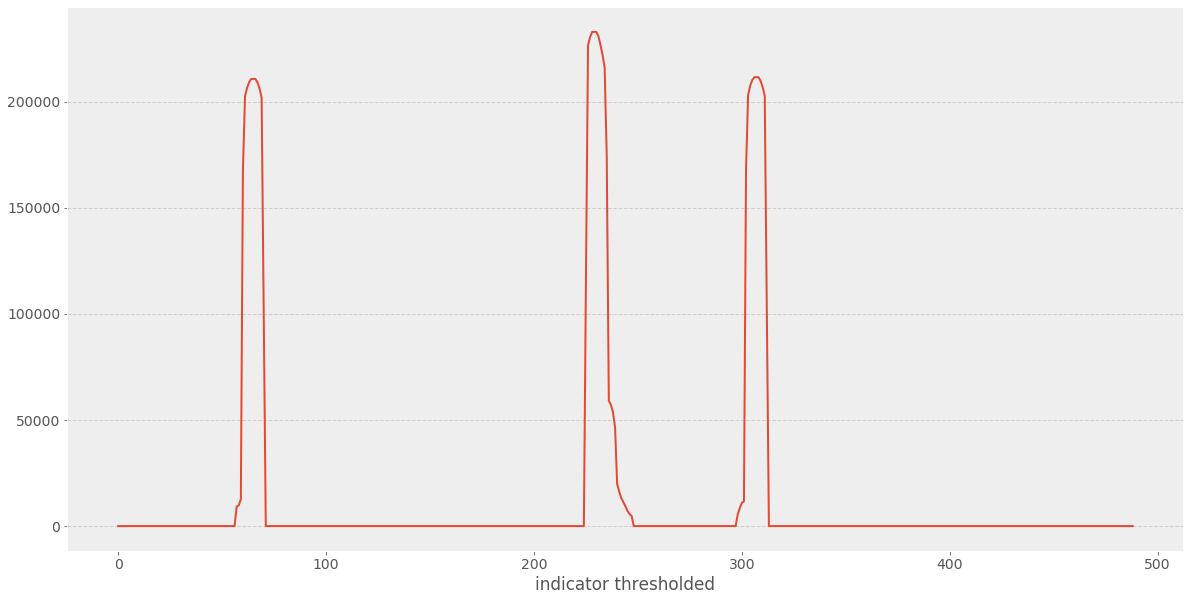

In [44]:
def indicator(SUP):
    w=10
    ind=[0]*w
    for i in range(w,len(SUP)-w):
        lt=SUP[i:i+w]
        rt=SUP[i-w:i]
        med_diff= statistics.median(rt)**2-statistics.median(lt)**2
        ind.append(math.sqrt(statistics.stdev(lt+rt) * abs(med_diff)))
    return ind

def indicator_thresh(ind):
    T= max(ind_med)*.02
    for i in range(len(ind)):
        if ind[i]<T:
            ind[i]=0
    return ind

#lst=smoothedSUPs[len(smoothedSUPs)-1]
lst=trimmedSUPs[0]
myplot(lst,'sup')

#Compute the indicator function
ind = indicator(lst)
plt.figure()
myplot(ind,'indicator')


#Smoothing the indicator function (optional)
plt.figure()
ind_med=moving_median(ind, 5)
myplot(ind_med,'indicator mving median')

# Applying threshold
ind_thresh= indicator_thresh(ind_med)

plt.figure()
myplot(ind_thresh,'indicator thresholded')


# Generating SSUPs

- 

distance=21.539457682983787


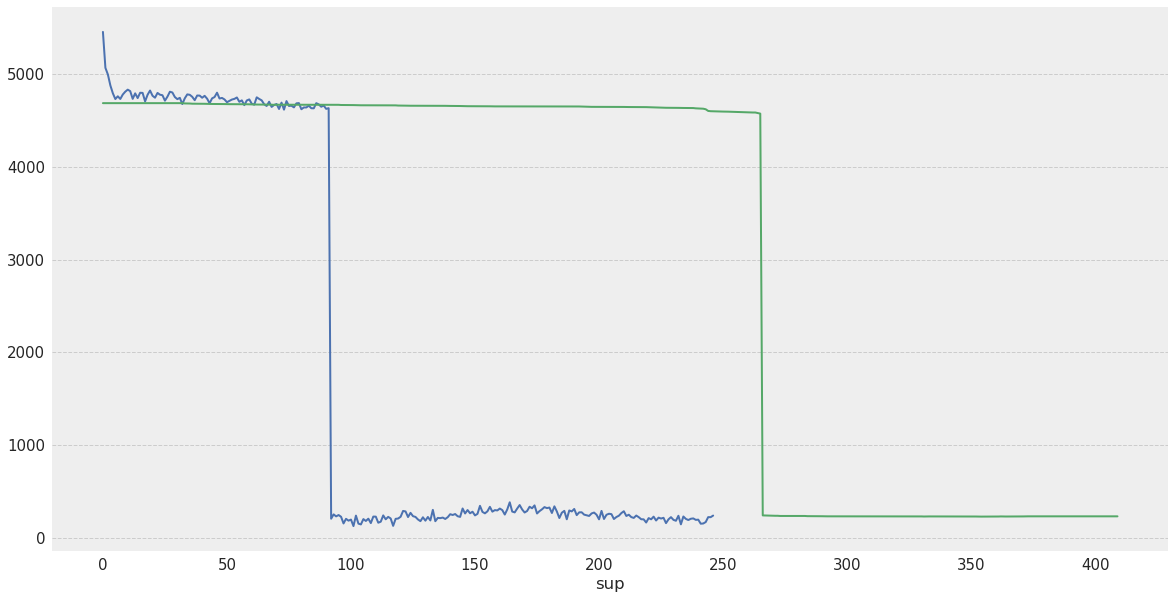

In [129]:
# Generating SSUPs

def get_noise(start,end,avg,stdev):
    #print(f'start:{start} end:{end} avg:{avg}')
    noise = np.random.normal(avg,stdev,end-start).tolist()
    return noise
def get_ripple(start,end,period,amplitude):
    x = np.linspace(start, end, end-start+1)
    ripple = (np.sin(x/period)*amplitude).tolist()
    return ripple

def get_cycle_linear(start, end, pwrlevel,pwrlevelstdv=1, noise_avg=0, noise_stdv=30, ripple_period=10 , ripple_amplitude=10, add_noise=False, add_ripple=False):
    pwrlevel = np.random.normal(pwrlevel,pwrlevelstdv)
    power = [pwrlevel] *(end-start)
    if add_noise:
        noise = get_noise(start,end,noise_avg,noise_stdv)
        noisy_cycle = [a + b for a, b in zip(noise, power)]
        power=noisy_cycle
    if add_ripple:    
        ripple = get_ripple(start, end, ripple_period,ripple_amplitude) 
        rippled_cycle = [a + b for a, b in zip(ripple, power)]
        power = rippled_cycle   
    return power

def get_cycle_oneoverx(start,end, avg, noise_stdv,top,top_stdv,ripple_period , ripple_amplitude, add_noise=False, add_ripple=False):
    x = np.linspace(start, end, end-start+1).tolist()
    top =  np.random.normal(top,top_stdv)
    y = [top/(i-start+1) for i in x]

    power = get_cycle_linear(start, end, avg,ripple_period=ripple_period , ripple_amplitude=ripple_amplitude, add_noise=add_noise, add_ripple=add_ripple, noise_stdv=noise_stdv)
    oneoverx_cycle = [a + b for a, b in zip(y, power)]
    return oneoverx_cycle

def get_thicks(ind, SUP):    
    thicks=[]
    s=-1
    e=-1
    thicks.append([0,0,0,'rise'])
    for i in range(len(ind)):
        if ind[i]>0 and s<0:
            s=i
        if ind[i]==0 and s>=0:
            e=i
            direction='rise'
            try:
                numThicks = len(thicks)
                if(SUP[thicks[numThicks-1][1]] > SUP[int((s+e)/2)]): #prev level > curr level --> fall
                    direction = 'fall'
            except:
                pass
            thicks.append([s,int((s+e)/2),e, direction])
            s=-1
            e=-1
    thicks.append([len(ind)-1,len(ind)-1,len(ind)-1,'fall'])
    return thicks


def get_SSUP(thicks,SUP,noise_stdv,top_mu,ripple_period , ripple_amplitude, edge_stdv):
   #skip the first
    SSUP=[]
    for i in range(1,len(thicks)):
        start= thicks[i-1][1]
        end= thicks[i][1]
        
        start =int( np.random.normal(start,edge_stdv))
        end = int(np.random.normal(end,edge_stdv))
        while start>=end:
            start =int(abs(np.random.normal(start,edge_stdv)))
            end = int(abs(np.random.normal(end,edge_stdv)))
        if start<0:
             start=0
        if start>=end:
            start =int(abs(np.random.normal(start,edge_stdv)))
            end = int(abs(np.random.normal(end,edge_stdv)))
        
#         avg = statistics.mean(lst[start:end])
#         avg_prev= statistics.median(SUP[start:end])

        avg=1
        try:
            avg = statistics.median(SUP[start:end])
        except:
            pass

        # print(f'state:{i-1} start:{start} end:{end} avg:{avg}')
        
        power=[]
        if thicks[i-1][3]=='rise':
            power = get_cycle_oneoverx(start,end, avg,top=top_mu,ripple_period=ripple_period , ripple_amplitude=ripple_amplitude,top_stdv=100, add_noise=True, add_ripple=True, noise_stdv=noise_stdv)
        else:
            power = get_cycle_linear(start, end, pwrlevel=avg,pwrlevelstdv=10, noise_avg=0, noise_stdv=noise_stdv,ripple_period=ripple_period , ripple_amplitude=ripple_amplitude, add_noise=True, add_ripple=True)
        SSUP = SSUP + power
    return SSUP




thicks = get_thicks(ind_thresh,lst)
# print(thicks)


SSUP = get_SSUP(thicks,lst,noise_stdv=30,top_mu=500,ripple_period=20 , ripple_amplitude=50,edge_stdv=100)

distance, path = fastdtw(lst, SSUP)
distance =distance/(len(lst)+len(SSUP))
print(f"distance={distance}")    
myplot(SSUP,'SSUP')
myplot(lst,'sup')



# comparing synthetic SUPs for an operation mode with SUPs in the same operation mode

means
97.93184192260563
stdv
36.648442265178176


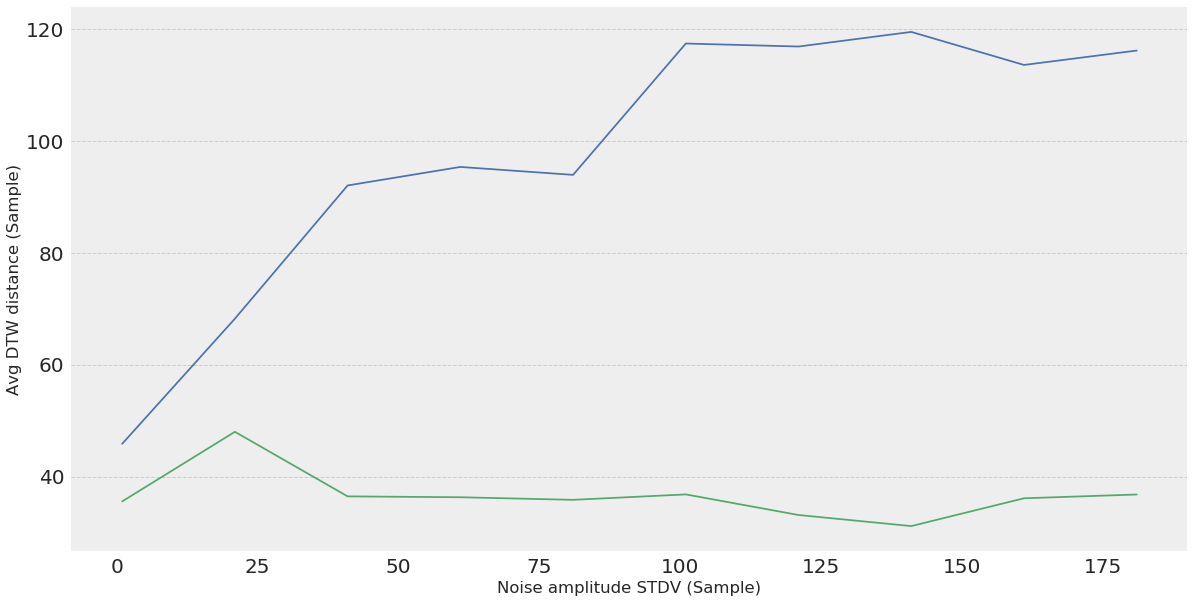

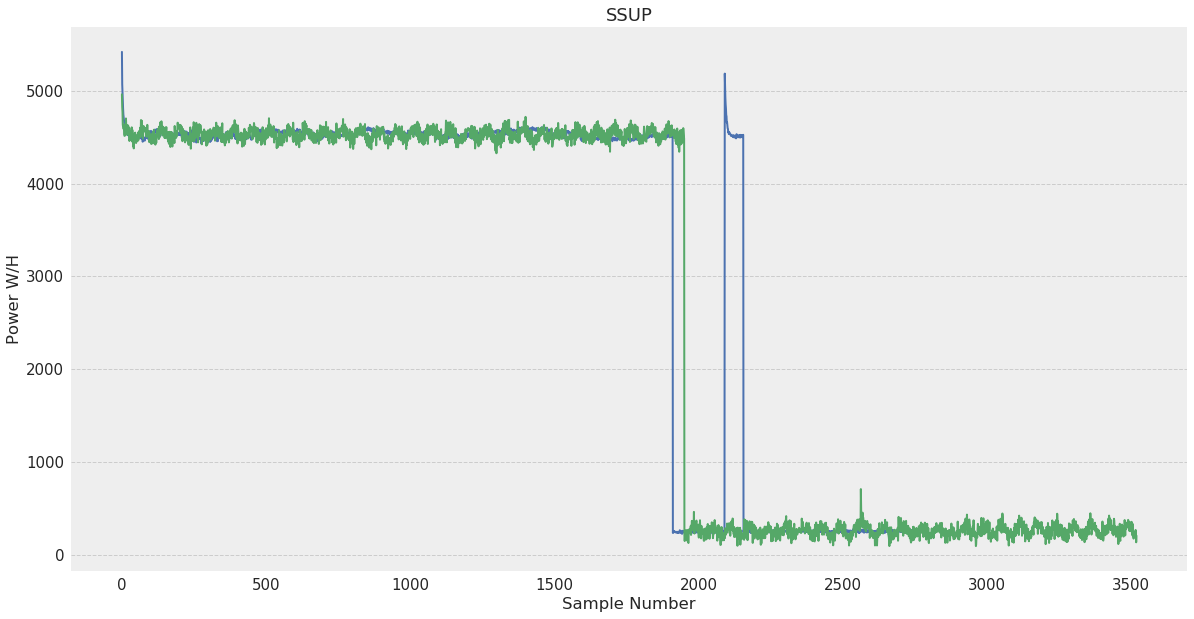

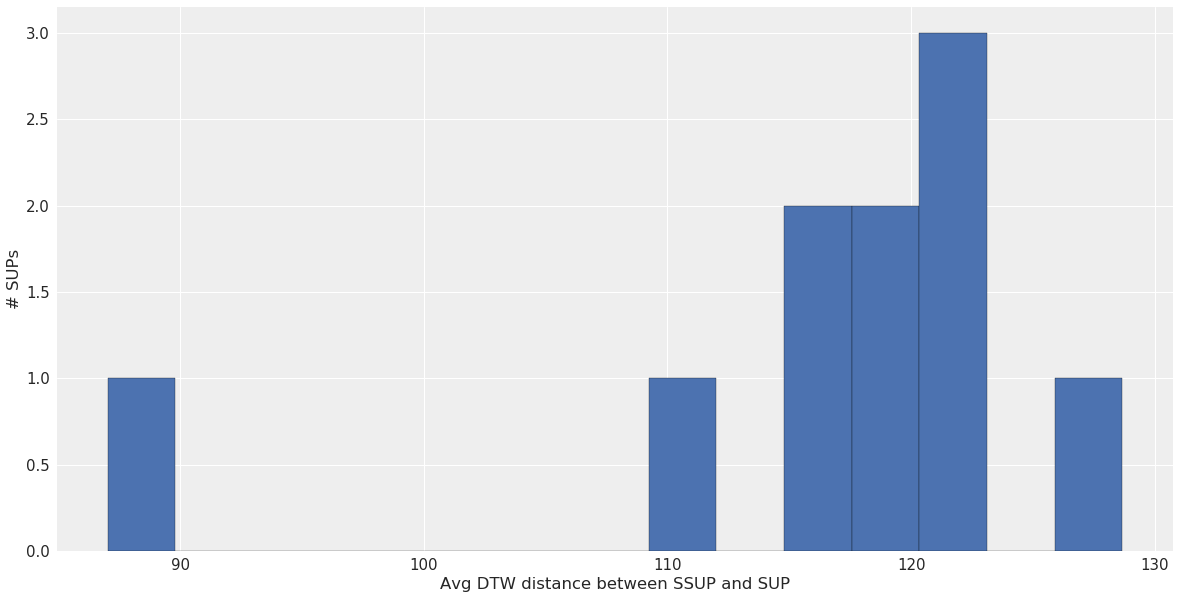

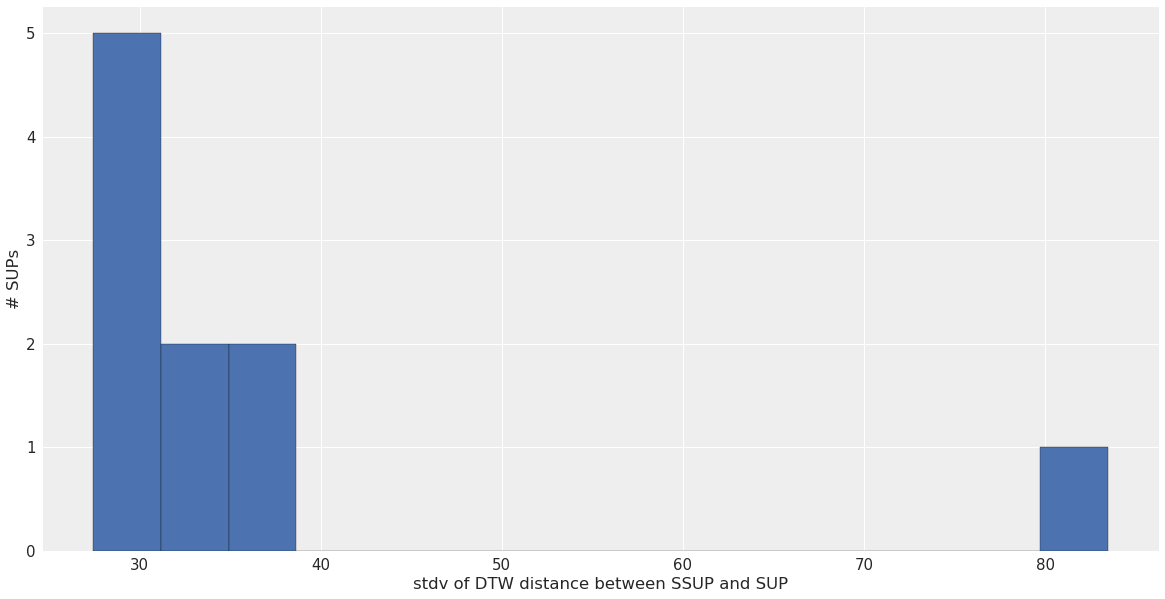

In [136]:
clusters=[]

clusters.append([1,'dryer','L', [0,1,2,3,4,5,6,7,8,9,11,12,13] ]) #10,
clusters.append([1,'dryer','M', [15,16,17] ])
clusters.append([1,'dryer','H', [18,19,21,22,23,24,25] ]) #20,

# clusters.append([2,'dryer','L', [0,1,2,3,4,5,6] ]) 
# clusters.append([2,'dryer','M', [7,8] ])
# clusters.append([2,'dryer','H', [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] ])

# clusters.append([1,'dishwasher','L', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] ]) 
# clusters.append([1,'dishwasher','M', [25,26,27,28,29,30,31,32] ]) 

# clusters.append([2,'dishwasher','L', [0,1,2,3,4,5,6,7,8,9,10] ]) 

# clusters.append([1,'washer','L', [0,1,2,3,4,5] ]) 
# clusters.append([1,'washer','M', [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] ]) 

# clusters.append([2,'washer','L', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] ]) 
# clusters.append([2,'washer','M', [15,16,17,18,19] ]) 
# clusters.append([2,'washer','H', [20,21,22,24,25,26] ]) #23,

clusterSUPs = clusters[0][3] # dryer - h1

# SUPlst = trimmedSUPs
SUPlst = smoothedSUPs

#change the tunning parameter range
grand_mean=[]
grand_stdv=[]
x_axis=[]

rng = list(range(1,200,20))
for c in rng:
    
    #noise_stdv = c
    noise_stdv = 50
    top_mu =500
    ripple_period =10
    ripple_amplitude =50
    
    edge_stdv =c
    x_axis.append(c)
 
    
    for c in range(0,len(clusterSUPs)):
        lst=SUPlst[clusterSUPs[c]]

        #Compute the indicator function
        ind = indicator(lst)

        #Smoothing the indicator function (optional)
        ind_med=moving_median(ind, 5)

        # Applying threshold
        ind_thresh= indicator_thresh(ind_med)

        #extract thick edges
        thicks = get_thicks(ind_thresh,lst)

        #generate synthetic SSUPs
        SSUPs=[]
        for i in range(0, 10):
            SSUPs.append(get_SSUP(thicks,lst,noise_stdv=noise_stdv,top_mu=top_mu,ripple_period=ripple_period , ripple_amplitude=ripple_amplitude,edge_stdv=edge_stdv))

        all_mean=[]
        all_stdv=[]

        for k in range(0, len(SSUPs)):
            SSUP = SSUPs[k]

            mean=[]
            stdv=[]
            distances=[]
            for j in range(0,len(clusterSUPs)):
                    distance, path = fastdtw(trimmedSUPs[clusterSUPs[j]], SSUP)
                    distance =distance/(len(trimmedSUPs[clusterSUPs[j]])+len(SSUP))
                    distances.append(distance)
            all_mean.append(np.mean(distances))
            all_stdv.append(np.std(distances))
    grand_mean.append(np.mean(all_mean))
    grand_stdv.append(np.mean(all_stdv))
        
#         plt.figure()
#         myplot(trimmedSUPs[clusterSUPs[c]],"Sample Number", "Power W/H","SUP")
#         myplot(SSUPs[0],"Sample Number", "Power W/H","SSUP")

        
        
plt.figure()
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.facecolor'] = '#eeeeee'
plt.rcParams['figure.figsize'] = (20, 10)
plt.grid(axis='y', color = '#cccccc', linestyle = '--', linewidth = 1)
plt.grid(axis='x', color = '#eeeeee', linestyle = '--', linewidth = 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Noise amplitude STDV (Sample)')
plt.ylabel('Avg DTW distance (Sample)')

plt.plot(x_axis,grand_mean)
plt.plot(x_axis,grand_stdv)

plt.savefig('eps/noiseDTW.eps', format='eps')


plt.figure()
myplot(trimmedSUPs[clusterSUPs[c]],"Sample Number", "Power W/H","SUP")
myplot(SSUPs[0],"Sample Number", "Power W/H","SSUP")


plt.figure()
plt.hist(all_mean, bins=15, edgecolor='black')
plt.xlabel("Avg DTW distance between SSUP and SUP")
plt.ylabel("# SUPs")

plt.figure()
plt.hist(all_stdv, bins=15, edgecolor='black')
plt.xlabel("stdv of DTW distance between SSUP and SUP")
plt.ylabel("# SUPs")

print('means')
print(np.mean(grand_mean))
print('stdv')
print(np.mean(grand_stdv))


# compare SSUPs to all other SUPs

26


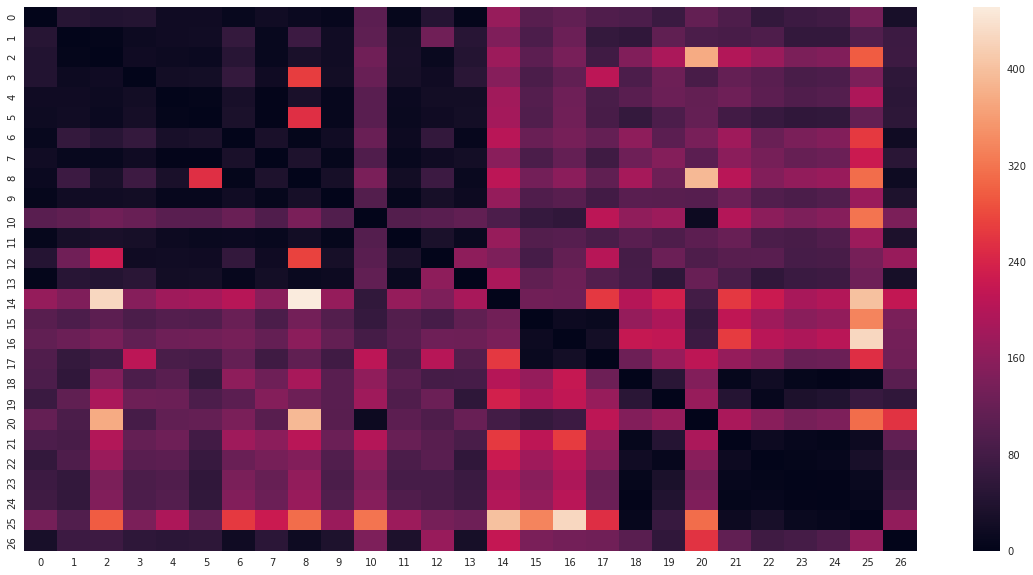

In [18]:
#All distances
distances1D=[]
distances2D=[]

#choose
# SUPlst = trimmedSUPs
SUPlst = smoothedSUPs
print(len(smoothedSUPs))
SUPlst.append(SSUP)
for i in range(0,len(SUPlst)):
    distances=[]
    for j in range(0,len(SUPlst)):
            distance, path = fastdtw(SUPlst[i], SUPlst[j])
            distance =distance/(len(SUPlst[i])+len(SUPlst[j]))
            distances.append(distance)
            distances1D.append(distance)
            #print('dist'+str(i)+" - "+str(j)+" = "+str(distance))
    distances2D.append(distances)

    
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)
sns.set()

ax = sns.heatmap(distances2D)

# SUPs clustering


In [ ]:
#pip install nose
#pip install tslearn
#
from tslearn.utils import to_time_series_dataset 
downsampled = [downsample(s,0.2) for s in trimmedSUPs]

X = to_time_series_dataset(downsampled)
y = [0, 0, 1]

# from tslearn.clustering import KernelKMeans
# gak_km = KernelKMeans(n_clusters=2, kernel="gak")
# labels_gak = gak_km.fit_predict(X)

# print(labels_gak)

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
labels = km.fit_predict(X)
silhouette_score(X, labels, metric="dtw")
print(labels)

# from tslearn.clustering import TimeSeriesKMeans
# km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
# labels = km.fit_predict(X)
# km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
# labels_bis = km_bis.fit_predict(X)
# print(labels_bis)

